In [1]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, accuracy

import seaborn as sns

2021-06-18 21:25:09,309 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-18 21:25:09,311 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-18 21:25:09,312 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-18 21:25:09,317 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-18 21:25:09,320 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-18 21:25:09,322 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=1732, out_features=128, bias=False)
  (batchNorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=128, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=22, bias=True)
)

## Load test dataset

In [5]:
dataset_name = 'html-5'


In [6]:
dataset = JDNDataset(datasets_list=[dataset_name])

  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-18 21:25:52,728 -INFO - dataset:dataset.py:255 - self.df.shape: (665, 24)
2021-06-18 21:25:52,729 -INFO - dataset:dataset.py:257 - Check for duplicates...
2021-06-18 21:25:52,731 -INFO - dataset:dataset.py:261 - Check for duplicates is OK
2021-06-18 21:25:52,748 -INFO - features_builder:features_builder.py:228 - used column: tag_name
2021-06-18 21:25:52,750 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-18 21:25:52,752 -INFO - features_builder:features_builder.py:228 - used column: tag_name_parent
2021-06-18 21:25:52,752 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-18 21:25:52,754 -INFO - features_builder:features_builder.py:228 - used column: tag_name_upsib
2021-06-18 21:25:52,755 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-18 21:25:52,756 -INFO - features_builder:features_builder.py:228 - used column: tag_name_dnsib
2021-06-18 21:25:52,757 -INF

  0%|          | 0/665 [00:00<?, ?it/s]

2021-06-18 21:25:52,834 -INFO - features_builder:features_builder.py:152 - used column: attributes_parent


  0%|          | 0/665 [00:00<?, ?it/s]

2021-06-18 21:25:52,906 -INFO - features_builder:features_builder.py:152 - used column: attributes_upsib


  0%|          | 0/665 [00:00<?, ?it/s]

2021-06-18 21:25:52,978 -INFO - features_builder:features_builder.py:152 - used column: attributes_dnsib


  0%|          | 0/665 [00:00<?, ?it/s]

2021-06-18 21:25:53,054 -INFO - dataset_collector:dataset_collector.py:53 - attributes_sm: (665, 17)
2021-06-18 21:25:53,054 -INFO - features_builder:features_builder.py:188 - used column: attributes
2021-06-18 21:25:53,055 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-18 21:25:53,060 -INFO - features_builder:features_builder.py:188 - used column: attributes_parent
2021-06-18 21:25:53,061 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-18 21:25:53,065 -INFO - features_builder:features_builder.py:188 - used column: attributes_upsib
2021-06-18 21:25:53,066 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-18 21:25:53,069 -INFO - features_builder:features_builder.py:188 - used column: attributes_dnsib
2021-06-18 21:25:53,070 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for

In [7]:
dataset.df.label.value_counts()

21    553
1      69
0       8
4       6
11      5
17      5
5       4
14      4
2       3
6       2
7       2
12      2
10      1
13      1
Name: label, dtype: int64

In [8]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, pin_memory=True)

In [10]:
results = []
softmax = torch.nn.Softmax(dim=1)
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = softmax(model(x.to(DEVICE))) # get prediction logits, and convert them to probabilities
            # print(y_pred.__repr__())
                                                   
            y_prob = y_pred.to('cpu').detach().numpy()
            y_pred = y_prob[0].argmax()
            
            y_prob = y_prob[0, y_pred].item()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_probability': y_prob,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df['is_hidden'] = dataset.df.is_hidden.values

  0%|          | 0/665 [00:00<?, ?it/s]

In [11]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'textfield',
 'dropdown',
 'checkbox',
 'radiobutton',
 'textarea',
 'fileinput',
 'iframe',
 'range',
 'progressbar',
 'datetimeselector',
 'colorpicker',
 'numberselector',
 'selector',
 'table',
 'switch',
 'slider',
 'tree-node',
 'steper',
 'tab',
 'n/a']

In [12]:
r_df = results_df[~((results_df.y_true_label == 'n/a') & (results_df.y_pred_label == 'n/a'))]

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=r_df.y_true_label.values,
                     y_pred=r_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [13]:
confusion_matrix_df

,button,link,textfield,dropdown,checkbox,radiobutton,textarea,fileinput,iframe,range,...,colorpicker,numberselector,selector,table,switch,slider,tree-node,steper,tab,n/a
button,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,68,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
textfield,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fileinput,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
range,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
import seaborn as sns


<AxesSubplot:>

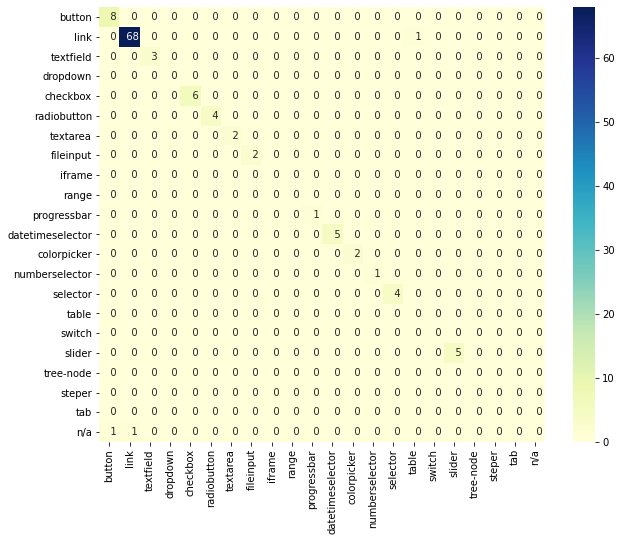

In [15]:
plt.figure(figsize=(10,8))
display(sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu"));
plt.show()
#display(sns.heatmap(confusion_matrix_df[:-1][confusion_matrix_df.columns[:-1]], annot=True, fmt="4d", cmap="YlGnBu"));
#plt.show();


In [16]:
dataset_name

'html-5'

In [17]:
accuracy(results_df)

2021-06-18 21:28:13,127 -INFO - common:common.py:464 - Accuracy:  26/27 = 0.9629629629629629, for 665 elements


0.9629629629629629

In [18]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'textfield': 2,
 'dropdown': 3,
 'checkbox': 4,
 'radiobutton': 5,
 'textarea': 6,
 'fileinput': 7,
 'iframe': 8,
 'range': 9,
 'progressbar': 10,
 'datetimeselector': 11,
 'colorpicker': 12,
 'numberselector': 13,
 'selector': 14,
 'table': 15,
 'switch': 16,
 'slider': 17,
 'tree-node': 18,
 'steper': 19,
 'tab': 20,
 'n/a': 21}

In [20]:

dataset.df['label_text_predicted'] = results_df.y_pred_label.values
dataset.df['probability'] = results_df.y_probability


(6208, 1200)


TypeError: unsupported operand type(s) for +: 'float' and 'str'

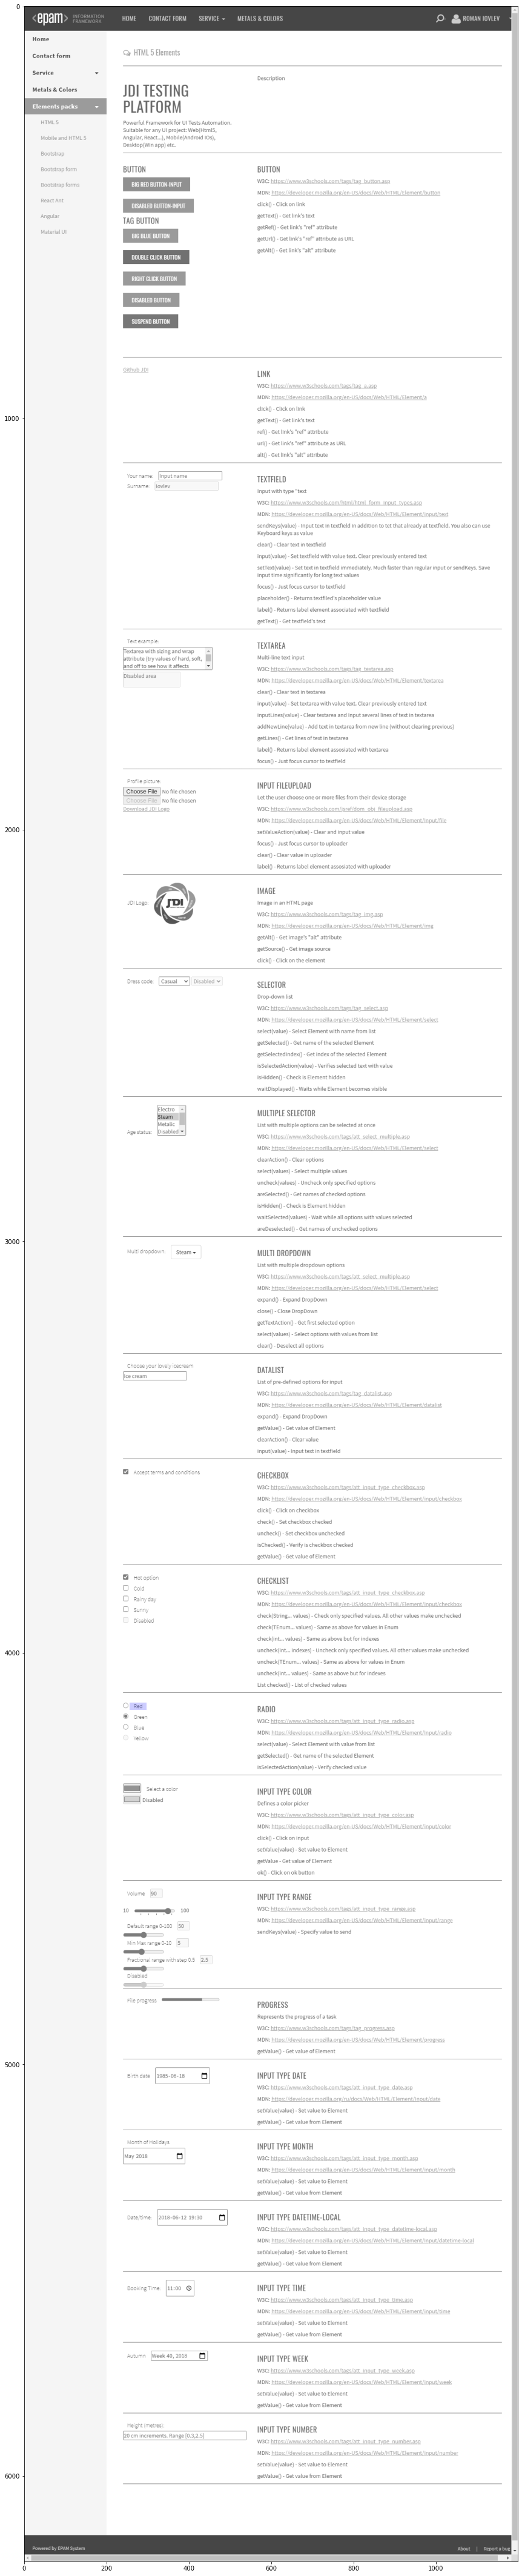

In [24]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.df[dataset.df.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.is_hidden == 1): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted+':'+str(round(r.probability, 5)), color='white', backgroundcolor='blue')

for i, r in dataset.df[dataset.df.label != dataset.classes_dict['n/a']].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [22]:
results_df

,y_true,y_pred,y_probability,y_true_label,y_pred_label,is_hidden
0,21,21,0.999967,n/a,n/a,0
1,21,21,1.000000,n/a,n/a,0
2,21,21,1.000000,n/a,n/a,0
3,21,21,1.000000,n/a,n/a,0
4,21,21,1.000000,n/a,n/a,0
...,...,...,...,...,...,...
660,21,21,0.999962,n/a,n/a,0
661,21,21,0.999940,n/a,n/a,0
662,21,21,0.999911,n/a,n/a,0
663,1,1,0.997421,link,link,0


In [23]:
dataset.dataset[:1].to_json(orient='records')

'[{"attributes":{"accept":null,"alt":null,"charset":null,"checked":null,"class":null,"cols":null,"content":null,"data-placement":null,"data-toggle":null,"dir":null,"disabled":null,"download":null,"for":null,"height":null,"href":null,"http-equiv":null,"id":null,"index":null,"lang":"en","language":null,"list":null,"max":null,"maxlength":null,"min":null,"minlength":null,"multiple":null,"name":null,"onchange":null,"onclick":null,"oncontextmenu":null,"ondblclick":null,"oninput":null,"placeholder":null,"rel":null,"required":null,"role":null,"rows":null,"selected":null,"size":null,"src":null,"step":null,"style":null,"tabindex":null,"target":null,"title":null,"type":null,"ui":null,"value":null,"width":null,"wrap":null},"displayed":true,"element_id":"6194400565668651573001447234","height":6225.0,"onmouseenter":null,"onmouseover":null,"parent_id":"6194400565668651573001447234","style":["align-content","align-items","align-self","alignment-baseline","animation-delay","animation-direction","animat

In [24]:
dataset.dataset.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'is_leaf', 'num_leafs', 'num_children',
       'sum_children_widths', 'sum_children_hights', 'children_tags',
       'num_followers', 'followers_tags', 'max_depth', 'attributes_parent',
       'displayed_parent', 'element_id_parent', 'height_parent',
       'onmouseenter_parent', 'onmouseover_parent', 'parent_id_parent',
       'style_parent', 'tag_name_parent', 'text_parent', 'width_parent',
       'x_parent', 'y_parent', 'is_hidden_parent', 'is_leaf_parent',
       'num_leafs_parent', 'num_children_parent', 'sum_children_widths_parent',
       'sum_children_hights_parent', 'children_tags_parent',
       'num_followers_parent', 'followers_tags_parent', 'max_depth_parent',
       'scalar', 'label', 'ds_name', 'cv_class', 'ohe_role', 'ohe_type',
       'ohe_ui', 'ohe_role_parent', 'ohe_type_parent', 'ohe_ui_paren